In [4]:
from rakuten_common import *

In [5]:
class EmbedRNN(RakutenBaseModel):
    """
    Modèle texte avec un layer Embedding et un layer GRU
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "std"):
            # Appel pour la création du modèle
            self.maxlen = 600
            self.num_words = 70000
            self.embedding_dim = 200
            self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.num_words)

    def get_class_weight(self):
        indices = {int(self.fit_labels[i]):i for i in self.fit_labels}
        cw = {i: 1 for i in range(NB_CLASSES)}
        #cw[indices[1280]] = 2
        return cw

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.maxlen,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.Embedding(self.num_words, self.embedding_dim,
                                      name=self.layer_name("embed"))(inp)
        x = tf.keras.layers.GRU(128, return_sequences=True,
                                name=self.layer_name("gru"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.GlobalAveragePooling1D(name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dense(256, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text(input_file)[off_start:off_end]
        self.tokenizer.fit_on_texts(X_train)
        self.word2idx = self.tokenizer.word_index
        self.idx2word = self.tokenizer.index_word
        self.vocab_size = self.tokenizer.num_words
        
        X_train = self.tokenizer.texts_to_sequences(X_train)
        X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                                maxlen=self.maxlen,
                                                                padding='post')
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = self.tokenizer.texts_to_sequences(X_test)
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                               maxlen=self.maxlen,
                                                               padding='post')

        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=8, patience_lr=3,
                                          class_weight=[])

In [ ]:
EmbedRNN().evaluate(NB_ECHANTILLONS)

In [4]:
class Multilingu(RakutenBaseModel):
    """
    Utilisation d'un modèle texte pré-entrainé (Multilingual-large) pour obtenir
    des vecteurs d'embedding.
    La fonction get_X_text_embed_multilingual() retourne ces vecteurs. Les plongements
    des phrases sont effectués lors de la première exécution et stocké dans un fichier
    qui est simplement lu par la suite.
    Pour utiliser ce mdèle il faut télécharger 
           https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3
    et l'extraire en tant que tfhub/universal-sentence-encoder-multilingual-large-3
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "std"):
            # Appel pour la création du modèle
            self.embedding_length = 512 # Défini par le modèle Multilingual/large
            self.std = StandardScaler()

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.embedding_length,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(inp)
        x = tf.keras.layers.Dense(200, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
#        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
#        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_train = self.std.fit_transform(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_test = self.std.transform(X_test)
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=7, patience_lr=3)

In [ ]:
Multilingu().evaluate(NB_ECHANTILLONS)

In [5]:
class NPDataset(tf.keras.utils.Sequence):
    """
    Générateur qui extrait les données (de type tableau numpy)
    à partir d'un path de fichier (passer par un fichier évite
    le risque de OOM avec les grosses matrices denses one hot)
    """
    def __init__(self, batch_size,
                 X, y=None, shuffle=False, random_state=1968):
        nb = len(X)
        self.y = y
        self.batch_size = batch_size
        self.batch_number = int(nb / batch_size)
        self.batch_indexes = range(self.batch_number)
        self.prefix = re.match(r'^(.*)_\d+\.npy$', X[0]).group(1)
        if shuffle:
            self.random_state = random_state
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=random_state)
        self.shuffle = shuffle

    def __len__(self):
        """ Retourne le nombre de batchs """
        return self.batch_number

    def __getitem__(self, index):
        index = self.batch_indexes[index]
        X = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            f = f"{self.prefix}_{i}.npy"
            with open(f, 'rb') as fd:
                x = np.load(fd)
                X.append(x)
        X = np.array(X)
        if self.y is None:
            return X
        else:
            y = self.y[index*self.batch_size : (index+1)*self.batch_size]
            return X, y

    def on_epoch_end(self):
        """ Changements effectués à chaque fin d'époque """
        if self.shuffle:
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=self.random_state)
        

class TextOneHot(RakutenBaseModel):
    """
    Mini modèle NN exécuté après un préprocessing des données effectué
    avec un pipe sklearn TfidfVectorizer | SelectFromModel(LinearSVC)
    
    Il faut télécharger la base de donnée Spacy pour le français:
                     python -m spacy download fr_core_news_sm
    Les textes sont tokenizés et lemattisés en utilisant Spacy, la fonction
    get_X_text_spacy_lemma() retourne ces textes préprocessés en les lisant
    dans un fichier qui est construit lors de la première utilisation.
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "select"):
            # Appel pour la création du modèle
            self.privatedir = os.path.join(OUTDIR, self.name)
            self.maxfeatures = 50000 # Nombre de features selectionnées par SVC
            self.select = make_pipeline(
                TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words, 
                  #    tokenizer=tokenize_spacy, # les données sont déjà tokenizées
                  preprocessor=' '.join,
                  lowercase=False,
                  stop_words=None,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
 #                 max_features=30000,  moins rentable que celui de SelectFromModel 
                  ),
                  SelectFromModel(LinearSVC(penalty="l2", dual=True, C=0.8,
                                            tol=1e-5, max_iter=4000),
                                  max_features=self.maxfeatures))

    def __flush_data_to_file(self, data, tag, off_start, off_end, input_file=None):
        if not os.path.isdir(self.privatedir):
            os.makedirs(self.privatedir)
        filelist = []
        for i in range(data.shape[0]):
            f = os.path.join(self.privatedir,
                             f"{tag}_{off_start}_{off_end}_{i}.npy")
            with open(f, 'wb') as fd:
                datum = data[i].toarray()[0]
                np.save(fd, datum)
            filelist.append(f)
        return filelist
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une donnée preprocessée à partir d'un fichier
        et la retourner
        """
        with open(filepath, 'rb') as fd:
            datum = np.load(fd)
        return datum

#    def get_class_weight(self):
#        indices = {int(self.fit_labels[i]):i for i in self.fit_labels}
#        cw = {i: 1 for i in range(NB_CLASSES)}
#        cw[indices[10]] = 2
#        return cw

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=self.input_shape, name=self.layer_name("input"))
        x = inp
        x = tf.keras.layers.Dense(90, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        y_train = get_y()[off_start:off_end]
#            X_train = get_X_text(input_file)[off_start:off_end]
        X_train = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_train = self.select.fit_transform(X_train, y_train)
        self.input_shape = X_train.shape[1:]
        self.prt(f"Nombre de mots retenus = {self.input_shape[0]}")
        return self.__flush_data_to_file(X_train, "train", off_start, off_end)

    def preprocess_X_test(self, off_start, off_end, input_file=None):
#        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_test = self.select.transform(X_test)
        return self.__flush_data_to_file(X_test, "test", off_start, off_end)

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)
        trainds = NPDataset(self.batch_size, X_train, y_train, shuffle=True)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)
        valds = NPDataset(self.batch_size, X_val, y_val, shuffle=True)

        self.model = self.get_model()

        return self.compile_and_train_dataset(trainds, valds,
                                              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                                              epochs=20,
                                              patience_stop=6, patience_lr=3)

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testds = NPDataset(1, X_test, shuffle=False)
        return self.model_predict(testds)

++ [18h55mn] TextOneHot: Evaluation avec 84916 échantillons
++ [18h55mn] TextOneHot: Nombre de mots retenus = 50000


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


++ [18h59mn] TextOneHot: fit(): Début
Epoch 1/20
1804/1804 [==============================] - 115s 63ms/step - loss: 1.6604 - accuracy: 0.6326 - val_loss: 0.8212 - val_accuracy: 0.8039
Epoch 2/20
1804/1804 [==============================] - 110s 61ms/step - loss: 0.7026 - accuracy: 0.8401 - val_loss: 0.5880 - val_accuracy: 0.8355
Epoch 3/20
1804/1804 [==============================] - 110s 61ms/step - loss: 0.4008 - accuracy: 0.9096 - val_loss: 0.5283 - val_accuracy: 0.8482
Epoch 4/20
1804/1804 [==============================] - 109s 60ms/step - loss: 0.2462 - accuracy: 0.9461 - val_loss: 0.5223 - val_accuracy: 0.8487
Epoch 5/20
1804/1804 [==============================] - 110s 61ms/step - loss: 0.1626 - accuracy: 0.9645 - val_loss: 0.5291 - val_accuracy: 0.8494
Epoch 6/20
1804/1804 [==============================] - 110s 61ms/step - loss: 0.1137 - accuracy: 0.9753 - val_loss: 0.5507 - val_accuracy: 0.8500
Epoch 7/20
1804/1804 [==============================] - 110s 61ms/step - loss: 0

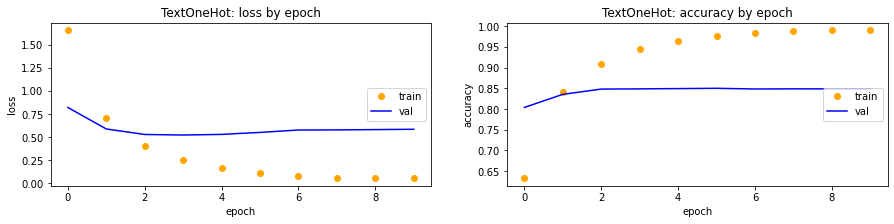

++ [19h18mn] TextOneHot: fit(): Fin

++ [19h19mn] TextOneHot: predict(): Début
16984/16984 [==============================] - 38s 2ms/step
++ [19h19mn] TextOneHot: predict(): Fin

++ [19h19mn] TextOneHot: w-f1-score = 0.8471

              precision    recall  f1-score   support

          10       0.54      0.65      0.59       652
        1140       0.82      0.81      0.81       541
        1160       0.95      0.95      0.95       815
        1180       0.83      0.65      0.73       140
        1280       0.74      0.74      0.74       956
        1281       0.67      0.63      0.65       399
        1300       0.94      0.96      0.95      1051
        1301       0.99      0.89      0.94       168
        1302       0.87      0.84      0.85       497
        1320       0.89      0.83      0.86       683
        1560       0.85      0.86      0.85       993
        1920       0.92      0.93      0.92       841
        1940       0.91      0.95      0.93       147
        2060     

In [6]:
TextOneHot().evaluate(NB_ECHANTILLONS)

In [6]:
class EffNetB1(RakutenBaseModel):
    """
    Modèle de transfert learning d'images avec EfficientNet et l'utilisation
    d'un générateur d'images augmentées.
    https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    Le modèle B5 a le format d'image (456x456) le plus proche de celles à
    classer (500x500), il est plus performant que B1 (~0.87 versus ~0.85)
    mais beaucoup plus coûteux en temps d'éxecution.
    """

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)
        self.preprocessing_function = None # Inclus dans le modèle
        self.basetrainable = 8
        self.epochs_freezed = 10
        self.epochs_unfreezed = 20
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
        return img

    def get_model_body(self):
        self.layer_index = 0
        self.basemodel = tf.keras.applications.EfficientNetB1(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        # Voyons quel est le type d'un élément
        print("Type d'un élément =", type(df.imgpath[0])) ###
        # Forcons le type à str (string)
        df.imgpath = df.imgpath.apply(str)###
        
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen

    def fit(self, off_start, off_val, off_end, input_file=None):

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train_dataset(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(lr=0.01),
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train_dataset(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(lr=0.00008),
                                    patience_lr=3,
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testgen = self.__get_test_dataset(X_test)
        return self.model_predict(testgen)

++ [18h22mn] EffNetB1: Evaluation avec 84916 échantillons
++ [18h22mn] EffNetB1: Création des générateurs d'images
Creation de modele_rakuten_out\X_train_update_image_path.pkl
Type d'un élément = <class 'str'>
Found 57743 validated image filenames belonging to 27 classes.
Found 10189 validated image filenames belonging to 27 classes.
++ [18h23mn] EffNetB1: Congélation des layers du modèle de base et entrainement
++ [18h23mn] EffNetB1: fit(): Début


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
1805/1805 [==============================] - 2348s 1s/step - loss: 1.8363 - accuracy: 0.4706 - val_loss: 1.5700 - val_accuracy: 0.5247
Epoch 2/10
1805/1805 [==============================] - 2398s 1s/step - loss: 1.6059 - accuracy: 0.5238 - val_loss: 1.5481 - val_accuracy: 0.5460
Epoch 3/10
1805/1805 [==============================] - 2358s 1s/step - loss: 1.5515 - accuracy: 0.5386 - val_loss: 1.4526 - val_accuracy: 0.5624
Epoch 4/10
1805/1805 [==============================] - 2367s 1s/step - loss: 1.5064 - accuracy: 0.5505 - val_loss: 1.4493 - val_accuracy: 0.5691
Epoch 5/10
1805/1805 [==============================] - 2342s 1s/step - loss: 1.4611 - accuracy: 0.5638 - val_loss: 1.4242 - val_accuracy: 0.5751
Epoch 6/10
1805/1805 [==============================] - 2407s 1s/step - loss: 1.4313 - accuracy: 0.5696 - val_loss: 1.3998 - val_accuracy: 0.5885
Epoch 7/10
1805/1805 [==============================] - 2433s 1s/step - loss: 1.4021 - accuracy: 0.5786 - val_loss: 1.3580 -

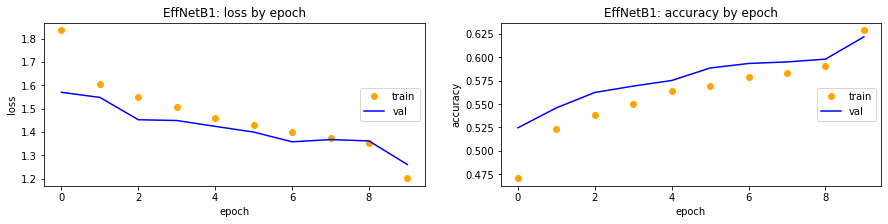

++ [10h21mn] EffNetB1: fit(): Fin

++ [10h21mn] EffNetB1: Décongélation des 8 derniers layers et entrainement
++ [10h21mn] EffNetB1: fit(): Début
Epoch 1/20
1805/1805 [==============================] - 2513s 1s/step - loss: 1.1647 - accuracy: 0.6399 - val_loss: 1.2469 - val_accuracy: 0.6250
Epoch 2/20
1805/1805 [==============================] - 2660s 1s/step - loss: 1.1177 - accuracy: 0.6514 - val_loss: 1.2237 - val_accuracy: 0.6341
Epoch 3/20
1805/1805 [==============================] - 3008s 2s/step - loss: 1.0821 - accuracy: 0.6630 - val_loss: 1.2210 - val_accuracy: 0.6367
Epoch 4/20
1805/1805 [==============================] - 2499s 1s/step - loss: 1.0532 - accuracy: 0.6715 - val_loss: 1.2137 - val_accuracy: 0.6378
Epoch 5/20
1805/1805 [==============================] - 2473s 1s/step - loss: 1.0242 - accuracy: 0.6812 - val_loss: 1.2036 - val_accuracy: 0.6405
Epoch 6/20
1805/1805 [==============================] - 3015s 2s/step - loss: 0.9977 - accuracy: 0.6882 - val_loss: 1.2136 -

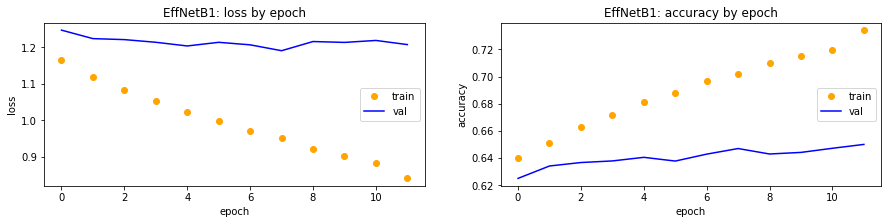

++ [18h58mn] EffNetB1: fit(): Fin

++ [18h58mn] EffNetB1: Entrainement terminé
Found 16984 validated image filenames.
++ [18h58mn] EffNetB1: predict(): Début
16984/16984 [==============================] - 774s 46ms/step
++ [19h11mn] EffNetB1: predict(): Fin

++ [19h11mn] EffNetB1: w-f1-score = 0.6479

              precision    recall  f1-score   support

          10       0.54      0.61      0.57       652
        1140       0.64      0.67      0.66       541
        1160       0.92      0.92      0.92       815
        1180       0.56      0.39      0.46       140
        1280       0.50      0.43      0.47       956
        1281       0.43      0.27      0.33       399
        1300       0.71      0.78      0.75      1051
        1301       0.76      0.67      0.72       168
        1302       0.51      0.47      0.49       497
        1320       0.50      0.48      0.49       683
        1560       0.61      0.59      0.60       993
        1920       0.79      0.81      0.80     

C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


++ [19h11mn] EffNetB1: Modèle sauvegardé dans modele_rakuten_out\EffNetB1_84916_model.hdf5
Pas de sauvegarde de  basemodel
++ [19h11mn] EffNetB1: Objet complet sauvegardé dans modele_rakuten_out\EffNetB1_84916_object.pkl


In [7]:
#https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
EffNetB1().evaluate(NB_ECHANTILLONS)

In [ ]:
class CatModel(RakutenCatModel):
    """
    Modèle qui concatene plusieurs modèles de base. ceux ci sont
    listés et instanciées dans self.objs. le paramètre nb permet
    de corréler les fichiers créés par les modèles de base et le
    modèle de concaténation, ils ont tous le même nb (en pratique
    il s'agit du nombre d'échantillons utilisés).
    
    Le modèle utilise un layer Keras concatenate après appel des
    méthodes get_model_body() de chaque modèle de base afin de
    récupérer l'architecture des layers de ces modèles.
    
         +----------+  +----------+  +----------+
         | modèle A |  | modèle B |  | modèle C |
         +-----+----+  +-----+----+  +-----+----+
               |             |             |
               +-------+     |    +--------+
                       |     |    |
                    +--v-----v----v--+
                    |   concatenate  |
                    +--------+-------+
                             |
                    +--------v-------+
                    |  top layerss   |
                    +----------------+
                    
    Une fois le modèle compilé, les poids des layers de bases sont
    initialisés avec ceux des objets modèles de base, grace à la
    méthode copy_submodules_weights().
    """
    def config(self, nb):
        """ Déclaration des modèles de base utilisés """
        if not hasattr(self, "objs") and nb is not None:
            self.objs = [
                         EmbedRNN(nb),
                         TextOneHot(nb),
                         Multilingu(nb),
                         EffNetB1(nb)
                        ]

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)

        self.config(nb)
        
    def fit(self, off_start, off_val, off_end, input_file=None):
        """
        Entrainement du modèle sur l'intervalle des données spécifié par
        off_start et off_end (offsets dans les fichiers de data).
        """

        self.prt(f'Chargements des modèles référencés "{self.nb}"')
        self.config(self.nb)

        # Générateurs qui alimenteront fit() avec les données train & val
        traingen, valgen = self.create_train_generators(off_start, off_val, off_end, input_file)
        
        self.prt(f"Création du modèle")
        # Récupèration des inputs et des outputs de chaque modèle de base
        # pour construire le modèle concatenate
        inputtensors, outputtensors = [], []
        for obj in self.objs:
            inp, outp = obj.get_model_body()
            inputtensors.append(inp)
            outputtensors.append(outp)
        
        self.layer_index = 0 # compteur utilisé dans get_model_body()
        
        tensors = outputtensors
#        outputtensors = []
#        for x in tensors:
#            x = BatchNormalization(name=self.layer_name("batchnorm"))(x)
#            x = Dense(128, activation='relu', name=self.layer_name("dense"))(x)
#            outputtensors.append(x)

        x = concatenate(outputtensors, axis=-1, name = self.layer_name("concatenate"))
#        x = Dense(64, activation='relu', name=self.layer_name("dense"))(x)
#        x = Dropout(0.2, name=self.layer_name("dropout"))(x)
#        x = BatchNormalization(name=self.layer_name("batchnorm"))(x)
        x = Dense(NB_CLASSES, activation='softmax', name=self.layer_name("dense"))(x)
        self.model = Model(inputtensors, x, name=self.name)

        #print(self.model.summary())

        print(f"  * Layers non entrainables:")
        for layer in self.model.layers:
            if layer.name.find(self.name) < 0:
                layer.trainable = False
                print(f"      - {layer.name}")
#        for layer in self.model.layers:
#            if 0 <= layer.name.find('efficient'):
#                layer.trainable = False
#                print(f"      - {layer.name}")
        print(f"  * Layers entrainables:")
        for layer in self.model.layers:
            if layer.trainable:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=0.001),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])

        # Initialisation des poids
        self.copy_submodels_weights()

        self.prt("fit(): Début")    
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min'),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1,
                                                          verbose=1)]
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=15,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)

        print(f"Décongélation des layers suivants:")
        for layer in self.model.layers:
            if not layer.trainable and layer.name.find("efficient") < 0:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=0.0001),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])


        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=15,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)

        return history

In [ ]:
CatModel().evaluate(NB_ECHANTILLONS)

In [ ]:
# Analyse des mauvaises prédictions à partir du fichier généré
# ne contenant que les mauvaises prédictions
badf = "modele_rakuten_out\CatModel_84916_bad_predictions.csv"
df = pd.read_csv(badf)

print("Classes les plus mal prédites:")
vc = df.y_test.value_counts()
display(pd.DataFrame(vc[:20]).transpose().rename(index = {'y_test': 'Erreurs'}))

plt.figure(figsize=(16,10))
sns.heatmap(pd.crosstab(df.y_test, df.y_pred))
plt.title("Matrice de confusion sur les mauvaise prédictions")
plt.show()

In [ ]:
# Sauvegarde des modèles et création du fichier csv des
# prédictions sur le fichier officiel de test
CatModel(NB_ECHANTILLONS).deliver()